# Assignment 1


In [1]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division

C:\Users\s115481\AppData\Local\Continuum\Anaconda3\envs\recomsys\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\s115481\AppData\Local\Continuum\Anaconda3\envs\recomsys\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [80]:
#create co-occurrence matrix
#print(tokenizer)
#print(corpus)
#print(nb_samples)
#print(V)
#print("\n")

def create_co_occurrence(crps, win_size, voc_size):
    # Discuss -1 with Thijs
    co_occurrence_mat = np.zeros((voc_size-1,voc_size-1), int)
    for sentence in crps:
        # Sliding window inside of sentence
        for i, center_word in enumerate(sentence):
            i_min = max(0, i - win_size + 1)
            i_max = min(len(sentence), i + win_size)
            window = sentence[i_min: i_max]
            #print("Window:", window)
            
            # Increment co occurence of words in sliding window
            for j in range(i_min, i_max):
                if i != j:
                    co_word = sentence[j]
                    co_occurrence_mat[center_word-1, co_word-1] += 1
    
    np.amax(co_occurrence_mat)
    
    return co_occurrence_mat

co_occurence = create_co_occurrence(corpus, window_size, V)

#Normalize
co_occurence = co_occurence / np.amax(co_occurence)
co_occurence

array([[0.        , 0.44444444, 0.48148148, ..., 0.03703704, 0.        ,
        0.        ],
       [0.44444444, 0.        , 0.07407407, ..., 0.03703704, 0.        ,
        0.        ],
       [0.48148148, 0.07407407, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03703704, 0.03703704, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [4]:
#find cosine similarity to Alice, Dinah and Rabbit
from scipy import spatial
print(tokenizer.word_index)

def cosine_sim(word_1, word_2, tknzr, matrix):
    word_1_ind = tknzr.word_index[word_1]
    word_2_ind = tknzr.word_index[word_2]
    
    #print(word_1, word_1_ind)
    #print(word_2, word_2_ind)
    
    word_1_vec = matrix[:,word_1_ind-1]
    word_2_vec = matrix[:,word_2_ind-1]
    
    #print(word_1_vec)
    #print(word_2_vec)
    
    similarity = 1 - spatial.distance.cosine(word_1_vec, word_2_vec)
    #print(similarity)
    
    return similarity
    
    
print('similarity of Alice and Dinah', str(cosine_sim("alice", "dinah", tokenizer, co_occurence)))
print('similarity of Alice and Rabbit', str(cosine_sim("alice", "rabbit", tokenizer, co_occurence)))
print('similarity of Dinah and Rabbit', str(cosine_sim("dinah", "rabbit", tokenizer, co_occurence)))


{'gravely': 1061, 'will': 191, 'splash': 882, 'mind': 248, 'pool': 137, 'wink': 912, 'make': 212, 'eaten': 707, 'cry': 493, 'suddenly': 175, 'pity': 1116, 'darkness': 817, 'general': 886, 'was': 9, 'thinking': 823, 'rather': 181, 'english': 228, 'call': 1086, 'corner': 435, 'hall': 147, 'hung': 615, 'golden': 188, 'short': 1065, 'elegant': 1064, 'exactly': 1058, 'ask': 263, 'crab': 576, 'reading': 588, 'case': 524, 'adoption': 1026, 'occurred': 598, 'returning': 808, 'name': 319, 'loveliest': 687, 'speak': 278, 'bring': 757, 'since': 1155, 'angrily': 1102, 'suppose': 527, 'hands': 514, 'bottle': 273, 'machines': 892, 'get': 67, 'two': 227, 'true': 629, 'eats': 772, 'time': 66, 'shiver': 997, 'others': 1111, 'bowed': 1072, 'explain': 561, 'we': 239, 'naturedly': 1153, 'story': 575, 'slippery': 751, 'seven': 832, 'asking': 423, 'air': 264, 'offended': 238, 'tell': 146, 'catch': 425, 'absurd': 1067, 'foot': 490, 'nonsense': 491, 'top': 405, 'children': 274, 'confusion': 1075, 'twenty': 83

In [110]:
#find the closest words to Alice
import pandas as pd

similarities = {i: cosine_sim("alice", i, tokenizer, co_occurence) if "alice"!= i else 0.0 for i in tokenizer.word_index}
pd_similarities = pd.DataFrame(list(similarities.items()), columns=['Word', 'Sim'])

top_5 = pd_similarities.sort_values(['Sim'], ascending=False)[:5]

print("Most similar word:\n", top_5)
#print(similarities)

Most similar word:
        Word       Sim
926    ahem  0.570483
626     ugh  0.570483
837     she  0.533538
341     say  0.530232
864  listen  0.498760


C:\Users\s115481\AppData\Local\Continuum\Anaconda3\envs\recomsys\lib\site-packages\scipy\spatial\distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


Discussion of the drawbacks:

In [114]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = co_occurence
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i-1,:]))))
    f.write("\n")
f.close()

In [115]:
#reopen your file as follows
co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


In [8]:
def generate_data_CBOW(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            out_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    out_words.append([word])
                    labels.append(words[i])
            if out_words != []:
                all_in.append(np_utils.to_categorical(labels, V))
                all_out.append(np.array(out_words,dtype=np.int32))
    return (all_in,all_out)

In [47]:
x,y = generate_data_CBOW(corpus, window_size, V)

for i in range(len(x)):
    print(x[i].shape)
    print(y[i].shape)

(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 

(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 118

(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 118

(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 118

(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 118

(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 118

(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 

(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(3, 1183)
(3, 1)
(2, 1183)
(2, 1)
(2, 1183)
(2, 1)
(3, 1183)
(3, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 1183)
(4, 1)
(4, 118

In [10]:
f = open('data_CBOW.txt' ,'w')

for input,outcome  in zip(x,y):
    input = np.concatenate(input)
    f.write(" ".join(map(str, list(input))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

In [45]:
#load the preprocessed Skipgram data
def generate_data_CBOW_from_file():
    f = open('data_CBOW.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        outputs = np.fromstring(outputs, dtype=int, sep=' ')
        print(outputs.shape)
        outputs = np.asarray(np.split(outputs, len(outputs)))
        inputs = np.fromstring(inputs, dtype=float, sep=' ')
        inputs = np.asarray(np.split(inputs, len(outputs)))
        print(inputs.shape)


        yield (inputs,outputs)
        

for x, y in generate_data_CBOW_from_file():
    pass

(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1

(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)


(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)


(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)


(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1

(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)


(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)


(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)


(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)


(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)


(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(3,)
(3, 1183)
(2,)
(2, 1183)
(2,)
(2, 1183)
(3,)
(3, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)
(4,)
(4, 1183)


In [13]:
generate_data_CBOW_from_file()

<generator object generate_data_CBOW_from_file at 0x00000196DE913F68>

In [25]:
#create CBOW model           
cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(V, activation='softmax'))

In [26]:
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [27]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data_CBOW_from_file():
        print('start')
        loss += cbow.train_on_batch(x, y)
    print(ite, loss)


Test
start


ValueError: Error when checking input: expected embedding_1_input to have shape (4,) but got array with shape (1,)

In [ ]:
#prepare data for Skipgram


In [ ]:
#create Skipgram model


In [ ]:
#define loss function for Skipgram


In [ ]:
#train Skipgram model


In [ ]:
#create CBOW model with additional dense layer        
dcbow = Sequential()
dcbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
dcbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
dcbow.add(Dense(V, activation='softmax'))

In [ ]:
#define loss function for CBOW + dense


In [ ]:
#train model for CBOW + dense


In [ ]:
#create Skipgram with additional dense layer


In [ ]:
#define loss function for Skipgram + dense


In [ ]:
#train model for Skipgram + dense


In [ ]:
#Implement your own analogy function


Comparison performance:

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1182 samples in 0.076s...
[t-SNE] Computed neighbors for 1182 samples in 2.457s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1182
[t-SNE] Computed conditional probabilities for sample 1182 / 1182
[t-SNE] Mean sigma: 0.691429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.322243
[t-SNE] Error after 1000 iterations: 1.497277


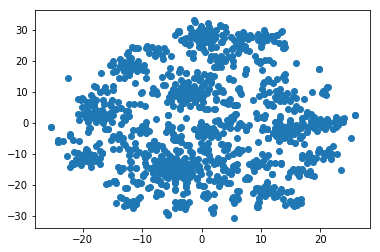

In [66]:
#Visualization results trained word embeddings

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_sne = 1000
tsne = TSNE(verbose=1)
tsne_results = tsne.fit_transform(co_occurence[:])

df_tsne = {}
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
%matplotlib inline

plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'])


Interpretation results of the visualization

Compare the results of the trained word embeddings with the word-word co-occurrence matrix

Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram

In [74]:
#load pretrained word embeddings of word2vec

path_word2vec = "data/GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)

In [71]:
#load pretraind word embeddings of Glove

path = "your path /glove.6B/glove.6B.300d_converted.txt"

#convert GloVe into word2vec format
gensim.scripts.glove2word2vec.get_glove_info(path)
gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format(path, binary=False)

NameError: name 'gensim' is not defined

In [75]:
#Visualize the pre-trained word embeddings
print(word2vec)


Comparison performance with your own trained word embeddings